# A Walk Through Ensemble Models
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. Please check the pdf file for more details.*

In this exercise you will:

- get to know a useful package **pandas** for data analysis/preprocessing
- implement **decision tree** and apply it to a Titanic dataset
- implement a whole bunch of **ensemble methods**, including **random forest, and adaboost**, and apply them to a Titanic dataset

Please note that **YOU CANNOT USE ANY MACHINE LEARNING PACKAGE SUCH AS SKLEARN** for any homework, unless you are asked to.

In [3]:
# some basic imports
from scipy import io
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import math
import re

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Let's first do some data preprocessing

Here we use [pandas](https://pandas.pydata.org/) to do data preprocessing. Pandas is a very popular and handy package for data science or machine learning. You can also refer to this official guide for pandas: [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html)

In [4]:
# read titanic train and test data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

print("train shape: {} test shape: {}".format(train.shape, test.shape))
# Showing overview of the train dataset
train.head(3)

train shape: (1047, 11) test shape: (262, 11)


,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,"Hays, Miss. Margaret Bechstein",female,24.0,0,0,11767,83.1583,C54,C
1,3,0,"Holm, Mr. John Fredrik Alexander",male,43.0,0,0,C 7075,6.4500,NaN,S
2,3,0,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S


## deal with missing values and transform to discrete variables

In [5]:
# copied from: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [6]:
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [7]:
train.head()

,Pclass,Survived,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,1,0,1,0,3,1,1,1,1,4
1,3,0,1,2,0,0,0,0,1,1,1
2,3,0,1,2,0,1,0,0,3,0,1
3,3,0,1,0,0,0,2,0,1,1,1
4,2,0,1,2,0,1,0,0,1,1,1


One of the good thing of pd.DataFrame is that you can keep the column names along with the data, which can be beneficial for many case.

Another good thing is that pd.DataFrame can be converted to np.array implicitly.

Also, pd provides a lot of useful data manipulating methods for your convenience, though we may not use them in this homework.

In [8]:
X = train.drop(['Survived'], axis=1)
y = train["Survived"]
X_test = test.drop(['Survived'], axis=1)
y_test = test["Survived"]
print("train: {}, test: {}".format(X.shape, X_test.shape))

train: (1047, 10), test: (262, 10)


In [9]:
def accuracy(y_gt, y_pred):
    return np.sum(y_gt == y_pred) / y_gt.shape[0]

In [10]:
print("Survived: {:.4f}, Not Survivied: {:.4f}".format(y.sum() / len(y), 1 - y.sum() / len(y)))

Survived: 0.3878, Not Survivied: 0.6122


## Decision Tree
Now it's your turn to do some real coding. Please implement the decision tree model in **decision_tree.py**. The PDF file provides some hints for this part.

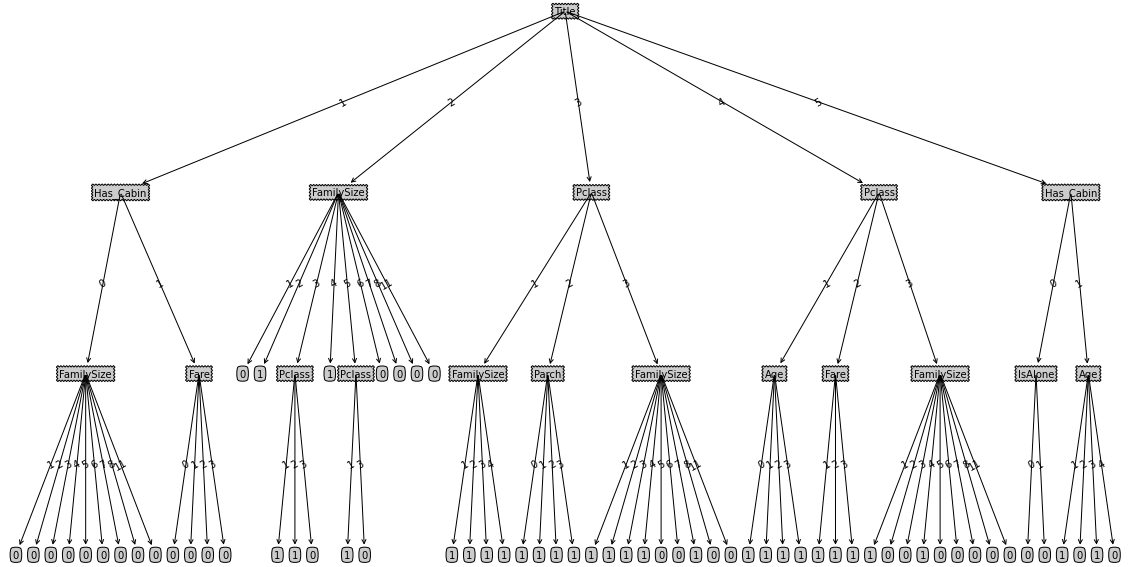

In [30]:
from decision_tree import DecisionTree

dt = DecisionTree(criterion='entropy', max_depth=3, min_samples_leaf=1, sample_feature=False)
dt.fit(X, y)

# Plot the decision tree to get an intuition about how it makes decision
plt.figure(figsize=(20, 10))
dt.show()

In [11]:
y_train_pred = dt.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.8233046800382043


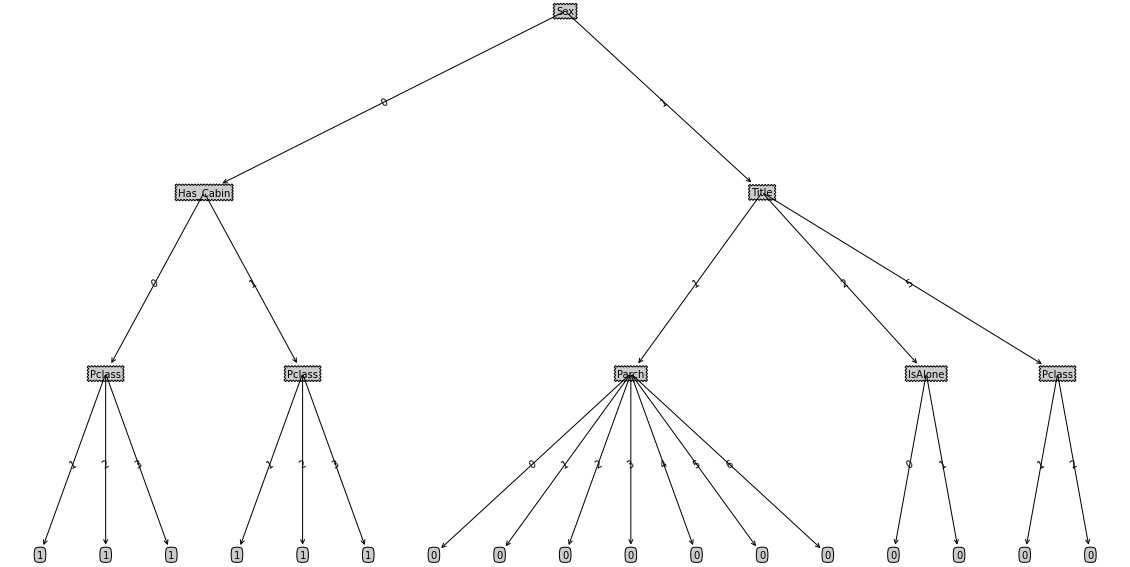

In [12]:
dt = DecisionTree(criterion='infogain_ratio', max_depth=3, min_samples_leaf=1, sample_feature=False)
dt.fit(X, y)

# Plot the decision tree to get an intuition about how it makes decision
plt.figure(figsize=(20, 10))
dt.show()

In [13]:
y_train_pred = dt.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.7822349570200573


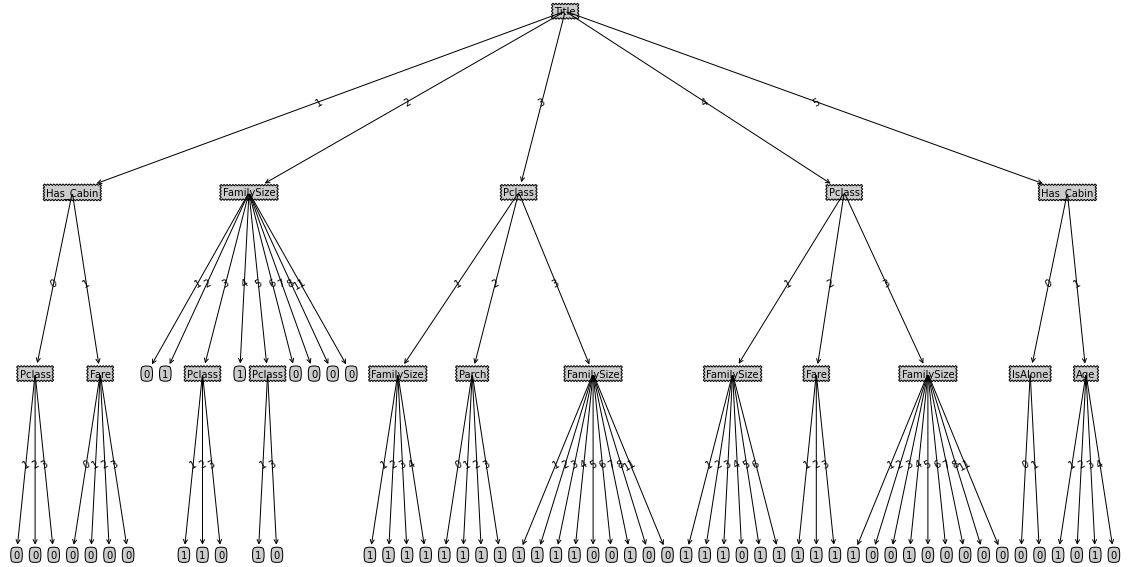

In [18]:
dt = DecisionTree(criterion='gini', max_depth=3, min_samples_leaf=1, sample_feature=False)
dt.fit(X, y)

# Plot the decision tree to get an intuition about how it makes decision
plt.figure(figsize=(20, 10))
dt.show()

In [19]:
y_train_pred = dt.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.8233046800382043


#### Code in the cell below aims to find good hyperparameters. Since my computer has poor performance and this code is time-consuming, the result shown here is just a demo. And the de facto output was gained by running this snippet on [Mo](https://mo.zju.edu.cn) platform.

In [132]:
# Train the best DecisionTree(best val accuracy) that you can. You should choose some 
# hyper-parameters such as critertion, max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# To reduce difficulty, you can use KFold here.
from sklearn.model_selection import KFold

SPLITS = 10

kf = KFold(n_splits=SPLITS, shuffle=True, random_state=2020)

max_depth_list = np.arange(2, 10)
metric_list = ['infogain_ratio', 'entropy', 'gini']
min_data_leaf_list = np.arange(1, 30)

best_dt = None
best_metric = None
best_max_depth = None
best_min_data_leaf = None
best_val_acc = 0

for metric in metric_list:
    for depth in max_depth_list:
        for min_data_leaf in min_data_leaf_list:
            dt = DecisionTree(criterion=metric, max_depth=depth, min_samples_leaf=min_data_leaf, sample_feature=False)

            for train_indice, valid_indice in kf.split(X, y):
                val_acc = 0
                X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                dt.fit(X_train_fold, y_train_fold)
                y_val_fold_pred = dt.predict(X_val_fold)
                val_acc = accuracy(y_val_fold, y_val_fold_pred)

                if val_acc >= best_val_acc:
                    best_dt = dt
                    best_metric = metric
                    best_max_depth = depth
                    best_min_data_leaf = min_data_leaf
                    best_val_acc = val_acc

print("metric: {}\nmax_depth: {}\nmin_data_leaf: {}\nbest_val_acc: {}".format(best_metric, best_max_depth,  best_min_data_leaf, best_val_acc))

best_metric: infogain_ratio
best_max_depth: 3
best_min_data_leaf: 1
best_avg_acc: 0.811818181818182


The optimal hyperparameters found from the snippet above are:
- criterion = 'entropy'
- max_depth = 2
- min_samples_leaf = 24

In [129]:
# report the accuracy on test set
best_dt = DecisionTree(criterion='entropy', max_depth=2, min_samples_leaf=24, sample_feature=False)
best_dt.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, best_dt.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, best_dt.predict(X_test))))

Accuracy on train set: 0.8013371537726839
Accuracy on test set: 0.8129770992366412


This cell is for Problem (a)(iv)

In [28]:
from sklearn.model_selection import KFold

SPLITS = 10

kf = KFold(n_splits=SPLITS, shuffle=True, random_state=2020)

max_depth_list = [3]
metric_list = ['entropy']
min_data_leaf_list = [1]

train_acc_arr = np.zeros((10, ))
val_acc_arr = np.zeros((10, ))

idx = 0

for metric in metric_list:
    for depth in max_depth_list:
        for min_data_leaf in min_data_leaf_list:
            dt = DecisionTree(criterion=metric, max_depth=depth, min_samples_leaf=min_data_leaf, sample_feature=False)

            for train_indice, valid_indice in kf.split(X, y):
                val_acc = 0
                X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                dt.fit(X_train_fold, y_train_fold)

                y_train_fold_pred = dt.predict(X_train_fold)
                train_acc = accuracy(y_train_fold, y_train_fold_pred)
                y_val_fold_pred = dt.predict(X_val_fold)
                val_acc = accuracy(y_val_fold, y_val_fold_pred)

                train_acc_arr[idx] = train_acc
                val_acc_arr[idx] = val_acc

                idx += 1

print("train_acc: {}, val_acc: {}".format(np.average(train_acc_arr), np.average(val_acc_arr)))



train_acc: 0.8247902186859033, val_acc: 0.7908058608058608


Code in this cell shows that the accuracy on the training set is not 1 even if *max_depth = infinity* and *min_samples_leaf = 1*, which means that this dataset is **inconsistent**.

In [31]:
from decision_tree import DecisionTree

dt = DecisionTree(criterion='entropy', max_depth=np.Infinity, min_samples_leaf=1, sample_feature=False)
dt.fit(X, y)
y_train_pred = dt.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.8758357211079274


## Random Forest
Please implement the random forest model in **random_forest.py**. The PDF file provides some hints for this part.

In [20]:
from random_forest import RandomForest

base_learner = DecisionTree(criterion='gini', max_depth=3, min_samples_leaf=1, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=50, seed=2020)
rf.fit(X, y)

y_train_pred = rf.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.8166189111747851


Code in the cell below aims to find good hyperparameters. Since my computer has poor performance and this code is time-consuming, the de facto output was gained by running this snippet on [Mo](https://mo.zju.edu.cn) platform.

In [ ]:
# Train the best RandomForest that you can. You should choose some 
# hyper-parameters such as max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
SPLITS = 100

kf = KFold(n_splits=SPLITS, shuffle=True, random_state=2020)

max_depth_list = np.arange(2, 10)
metric_list = ['infogain_ratio', 'entropy', 'gini']
min_data_leaf_list = np.arange(1, 30)
n_estimator_list = np.arange(5, 21)

best_rf = None
best_metric = None
best_max_depth = None
best_min_data_leaf = None
best_n_estimator = None
best_val_acc = 0

for metric in metric_list:
    for depth in max_depth_list:
        for min_data_leaf in min_data_leaf_list:
            base_learner = DecisionTree(criterion=metric, max_depth=depth, min_samples_leaf=min_data_leaf, sample_feature=True)
            for n_estimator in n_estimator_list:

                rf = RandomForest(base_learner=base_learner, n_estimator=n_estimator, seed=2020)

                for train_indice, valid_indice in kf.split(X, y):
                    val_acc = 0
                    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                    rf.fit(X_train_fold, y_train_fold)
                    y_val_fold_pred = rf.predict(X_val_fold)
                    val_acc = accuracy(y_val_fold, y_val_fold_pred)

                    if val_acc >= best_val_acc:
                        best_rf = rf
                        best_metric = metric
                        best_max_depth = depth
                        best_min_data_leaf = min_data_leaf
                        best_n_estimator = n_estimator
                        best_val_acc = val_acc

print("metric: {}\nmax_depth: {}\nmin_data_leaf: {}\nn_estimator: {}\nbest_val_acc: {}".format(best_metric, best_max_depth, best_min_data_leaf, best_n_estimator, best_val_acc))

The optimal hyperparameters found from the snippet above are:
- criterion = 'entropy'
- max_depth = 8
- min_samples_leaf = 20
- n_estimator = 10

In [19]:
from decision_tree import DecisionTree
from random_forest import RandomForest

# report the accuracy on test set
base_learner = DecisionTree(criterion='entropy', max_depth=8, min_samples_leaf=20, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=10, seed=2020)

rf.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))

Accuracy on train set: 0.8252148997134671
Accuracy on test set: 0.8206106870229007


This cell is for Problem (b)(ii)

In [15]:
from sklearn.model_selection import KFold
from decision_tree import DecisionTree
from random_forest import RandomForest

SPLITS = 10

kf = KFold(n_splits=SPLITS, shuffle=True, random_state=2020)

max_depth_list = [8]
metric_list = ['entropy']
min_data_leaf_list = [20]
n_estimator_list = [10, 100]

train_acc_arr = np.zeros((10, 2))
val_acc_arr = np.zeros((10, 2))
row_idx = 0
col_idx = 0

for metric in metric_list:
    for depth in max_depth_list:
        for min_data_leaf in min_data_leaf_list:
            base_learner = DecisionTree(criterion=metric, max_depth=depth, min_samples_leaf=min_data_leaf, sample_feature=True)
            for n_estimator in n_estimator_list:

                rf = RandomForest(base_learner=base_learner, n_estimator=n_estimator, seed=2020)

                for train_indice, valid_indice in kf.split(X, y):
                    val_acc = 0
                    train_acc = 0
                    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                    rf.fit(X_train_fold, y_train_fold)

                    y_train_fold_pred = rf.predict(X_train_fold)
                    train_acc = accuracy(y_train_fold, y_train_fold_pred)

                    y_val_fold_pred = rf.predict(X_val_fold)
                    val_acc = accuracy(y_val_fold, y_val_fold_pred)

                    train_acc_arr[row_idx, col_idx] = train_acc
                    val_acc_arr[row_idx, col_idx] = val_acc

                    row_idx += 1
                
                row_idx = 0
                col_idx += 1
            
            col_idx = 0

print("train_acc for n = 10 and n = 100: {}".format(np.average(train_acc_arr, axis=0)))
print("val_acc for n = 10 and n = 100: {}".format(np.average(val_acc_arr, axis=0)))

train_acc for n = 10 and n = 100: [0.83593356 0.84399869]
val_acc for n = 10 and n = 100: [0.7965293  0.79654762]


This cell is for Problem (b)(iii)

In [18]:
from decision_tree import DecisionTree
from random_forest import RandomForest

# report the accuracy on test set
base_learner = DecisionTree(criterion='entropy', max_depth=8, min_samples_leaf=20, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=10, seed=2020)

base_learner.fit(X, y)
rf.fit(X, y)

print("DT Accuracy on train set: {}".format(accuracy(y, base_learner.predict(X))))
print("DT Accuracy on test set: {}".format(accuracy(y_test, base_learner.predict(X_test))))

print("RF Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("RF Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))

DT Accuracy on train set: 0.8299904489016237
DT Accuracy on test set: 0.7938931297709924
RF Accuracy on train set: 0.836676217765043
RF Accuracy on test set: 0.8129770992366412


## Adaboost
Please implement the adaboost model in **adaboost.py**. The PDF file provides some hints for this part.

In [21]:
from adaboost import Adaboost

base_learner = DecisionTree(criterion='gini', max_depth=3, min_samples_leaf=1, sample_feature=False)
ada = Adaboost(base_learner=base_learner, n_estimator=50, seed=2020)
ada.fit(X, y)

y_train_pred = ada.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.828080229226361


#### Code in the cell below aims to find good hyperparameters. Since my computer has poor performance and this code is time-consuming, the de facto output was gained by running this snippet on [Mo](https://mo.zju.edu.cn) platform.

In [ ]:
# TODO: Train the best Adaboost that you can. You should choose some 
# hyper-parameters such as max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# begin answer
from decision_tree import DecisionTree
from sklearn.model_selection import KFold
from adaboost import Adaboost

SPLITS = 5

kf = KFold(n_splits=SPLITS, shuffle=True, random_state=2020)

# max_depth_list = [1, 2, 3, 4, 5]
max_depth_list = [1, 2, 3, 4, 5]
metric_list = ['entropy']
min_data_leaf_list = [1, 5, 10, 20, 30, 40, 50]
n_estimator_list = [10, 100, 200, 300]
# min_data_leaf_list = [1, 5, 10, 20]
# n_estimator_list = [10]

cnt = 0

best_rf = None
best_metric = None
best_max_depth = None
best_min_data_leaf = None
best_n_estimator = None
best_val_acc = 0

best_avg_rf = None
best_avg_metric = None
best_avg_depth = None
best_avg_data_leaf = None
best_avg_n_estimator = None
best_avg_acc = 0

for metric in metric_list:
    for depth in max_depth_list:
        for min_data_leaf in min_data_leaf_list:
            base_learner = DecisionTree(criterion=metric, max_depth=depth, min_samples_leaf=min_data_leaf, sample_feature=False)
            for n_estimator in n_estimator_list:

                rf = Adaboost(base_learner=base_learner, n_estimator=n_estimator, seed=2020)
                avg_acc = 0

                for train_indice, valid_indice in kf.split(X, y):
                    val_acc = 0
                    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                    rf.fit(X_train_fold, y_train_fold)
                    y_val_fold_pred = rf.predict(X_val_fold)
                    val_acc = accuracy(y_val_fold, y_val_fold_pred)
                    avg_acc += val_acc

                    if val_acc >= best_val_acc:
                        best_rf = rf
                        best_metric = metric
                        best_max_depth = depth
                        best_min_data_leaf = min_data_leaf
                        best_n_estimator = n_estimator
                        best_val_acc = val_acc

                avg_acc /= SPLITS

                cnt += 1
                print("{} passed.".format(cnt))

                if avg_acc >= best_avg_acc:
                    best_avg_rf = rf
                    best_avg_metric = metric
                    best_avg_depth = depth
                    best_avg_data_leaf = min_data_leaf
                    best_avg_n_estimator = n_estimator
                    best_avg_acc = val_acc


print("metric: {}\nmax_depth: {}\nmin_data_leaf: {}\nn_estimator: {}\nbest_val_acc: {}".format(best_metric, best_max_depth, best_min_data_leaf, best_n_estimator, best_val_acc))
print("metric: {}\nmax_depth: {}\nmin_data_leaf: {}\nn_estimator: {}\nbest_avg_acc: {}".format(best_avg_metric, best_avg_depth, best_avg_data_leaf, best_avg_n_estimator, best_avg_acc))

# end answer

The optimal hyperparameters found from the snippet above are:
- criterion = 'entropy'
- max_depth = 3
- min_samples_leaf = 20
- n_estimator = 10

In [14]:
# report the accuracy on test set
# begin answer
from decision_tree import DecisionTree
from adaboost import Adaboost

base_learner = DecisionTree(criterion='entropy', max_depth=3, min_samples_leaf=20, sample_feature=False)
ada = Adaboost(base_learner=base_learner, n_estimator=10, seed=2020)
# end answer
ada.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, ada.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, ada.predict(X_test))))

Accuracy on train set: 0.8233046800382043
Accuracy on test set: 0.8015267175572519


This cell is for Problem (c)(ii)

In [16]:
from sklearn.model_selection import KFold
from decision_tree import DecisionTree
from adaboost import Adaboost

SPLITS = 10

kf = KFold(n_splits=SPLITS, shuffle=True, random_state=2020)

max_depth_list = [3]
metric_list = ['entropy']
min_data_leaf_list = [20]
n_estimator_list = [10, 100]

train_acc_arr = np.zeros((10, 2))
val_acc_arr = np.zeros((10, 2))
row_idx = 0
col_idx = 0

for metric in metric_list:
    for depth in max_depth_list:
        for min_data_leaf in min_data_leaf_list:
            base_learner = DecisionTree(criterion=metric, max_depth=depth, min_samples_leaf=min_data_leaf, sample_feature=False)
            for n_estimator in n_estimator_list:

                rf = Adaboost(base_learner=base_learner, n_estimator=n_estimator, seed=2020)

                for train_indice, valid_indice in kf.split(X, y):
                    val_acc = 0
                    train_acc = 0
                    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                    rf.fit(X_train_fold, y_train_fold)

                    y_train_fold_pred = rf.predict(X_train_fold)
                    train_acc = accuracy(y_train_fold, y_train_fold_pred)

                    y_val_fold_pred = rf.predict(X_val_fold)
                    val_acc = accuracy(y_val_fold, y_val_fold_pred)

                    train_acc_arr[row_idx, col_idx] = train_acc
                    val_acc_arr[row_idx, col_idx] = val_acc

                    row_idx += 1
                
                row_idx = 0
                col_idx += 1
            
            col_idx = 0

print("train_acc for n = 10 and n = 100: {}".format(np.average(train_acc_arr, axis=0)))
print("val_acc for n = 10 and n = 100: {}".format(np.average(val_acc_arr, axis=0)))

train_acc for n = 10 and n = 100: [0.8251088  0.82638213]
val_acc for n = 10 and n = 100: [0.79081502 0.78891026]


This cell is for Problem (c)(iii)

In [19]:
from decision_tree import DecisionTree
from adaboost import Adaboost

# report the accuracy on test set
base_learner = DecisionTree(criterion='entropy', max_depth=3, min_samples_leaf=20, sample_feature=False)
rf = Adaboost(base_learner=base_learner, n_estimator=10, seed=2020)

base_learner.fit(X, y)
rf.fit(X, y)

print("DT Accuracy on train set: {}".format(accuracy(y, base_learner.predict(X))))
print("DT Accuracy on test set: {}".format(accuracy(y_test, base_learner.predict(X_test))))

print("RF Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("RF Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))

DT Accuracy on train set: 0.8213944603629417
DT Accuracy on test set: 0.7977099236641222
RF Accuracy on train set: 0.8233046800382043
RF Accuracy on test set: 0.8015267175572519


## Comparision
*Sklearn* was used for all classifiers here.
### Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

y_train_pred = gnb.fit(X, y).predict(X)
y_test_pred = gnb.fit(X, y).predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.7679083094555874
Accuracy on test set: 0.7595419847328244


### Perceptron

In [33]:
from sklearn.linear_model import Perceptron

clf = Perceptron()
y_train_pred = clf.fit(X, y).predict(X)
y_test_pred = clf.fit(X, y).predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.45176695319961796
Accuracy on test set: 0.42366412213740456


### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
y_train_pred = clf.fit(X, y).predict(X)
y_test_pred = clf.fit(X, y).predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.7956064947468959
Accuracy on test set: 0.7938931297709924


### SVM

In [39]:
from sklearn import svm

clf = svm.SVC()
y_train_pred = clf.fit(X, y).predict(X)
y_test_pred = clf.fit(X, y).predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.8185291308500477
Accuracy on test set: 0.8129770992366412


### Neural Network

In [40]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
y_train_pred = clf.fit(X, y).predict(X)
y_test_pred = clf.fit(X, y).predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.8185291308500477
Accuracy on test set: 0.7977099236641222


### KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
y_train_pred = clf.fit(X, y).predict(X)
y_test_pred = clf.fit(X, y).predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.830945558739255
Accuracy on test set: 0.8206106870229007


### Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
y_train_pred = clf.fit(X, y).predict(X)
y_test_pred = clf.fit(X, y).predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.8758357211079274
Accuracy on test set: 0.7900763358778626


### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
y_train_pred = clf.fit(X, y).predict(X)
y_test_pred = clf.fit(X, y).predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.8758357211079274
Accuracy on test set: 0.8282442748091603


### Adaboost

In [46]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
y_train_pred = clf.fit(X, y).predict(X)
y_test_pred = clf.fit(X, y).predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.8118433619866284
Accuracy on test set: 0.7977099236641222
